<a href="https://colab.research.google.com/github/Davit000Asryan/My-projects/blob/main/MNIST_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms


In [3]:
# checking if a GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# making a preprocessor pipeline for the data

preprocessor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])


# download the data

train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = preprocessor
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = preprocessor
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 433kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.05MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.33MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
train_data.targets.shape

torch.Size([60000])

In [8]:
# defining a dictionary  with data loaders
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data,
                         batch_size = 100,
                         shuffle = True),

    'test' : DataLoader(test_data,
                        batch_size = 100,
                        shuffle = True)
}

In [9]:
# neural network architecture

class Model(nn.Module):
    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fcl1 = nn.Linear(in_features=128*7*7, out_features=64)
        self.out_layer = nn.Linear(in_features=64, out_features=10)
        self.p=0.01


    # forward method with ReLu activation functions
    def forward(self, x):
        x = F.dropout(F.relu(self.conv1(x)),p=self.p)
        x = F.dropout(F.relu(self.conv2(x)),p=self.p)
        x = self.pool1(x)
        x = F.dropout(F.relu(self.conv3(x)),p=self.p)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(F.relu(self.fcl1(x)), p=self.p)
        x = self.out_layer(x)

        return x



In [10]:
# instantiating the model, optimizer and loss
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
loss_f = nn.CrossEntropyLoss()

# creating caches for losses
train_losses = []
test_losses = []


In [11]:
# training
epochs = 3

# making a counters for calculating accuracy
train_total_correct = 0
train_total = 0


# putting the model into training mode
model.train()

for epoch in range(epochs):
  for batch_idx, (train_inputs, train_labels) in enumerate(loaders['train']):

    # moving the data to the GPU
    train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

    # making the gradients zero
    optimizer.zero_grad()

    # predicting the outputs
    train_preds = model(train_inputs)

    #count and cache the loss
    train_loss = loss_f(train_preds, train_labels)

    # using .item() to store only numeric values
    train_losses.append(train_loss.item())

    # backprop
    train_loss.backward()

    # ubdate the parameters
    optimizer.step()

    # tracking the training losses
    if ((epoch*600)+batch_idx) % 200 == 0:
      print(f'For training batch index: {(epoch*600)+batch_idx} the loss is: {train_loss.item()}')


    # get the predicted classes
    train_pred_classes = train_preds.argmax(dim=1)

    # compare predictions with true labels
    train_correct_predictions = (train_pred_classes == train_labels)

    # calculate the total number of correct predictions and convert to a python number
    train_total_correct += train_correct_predictions.sum().item()
    train_total += train_labels.size(0)

# calculate the mean train loss over all batches
mean_train_loss = sum(train_losses) / len(train_losses)

print(f'The mean train loss: {mean_train_loss}')


# calculate the accuracy
train_accuracy = (train_total_correct / train_total)*100

print(f'Training accuracy: {train_accuracy} %')


For training batch index: 0 the loss is: 2.318530797958374
For training batch index: 200 the loss is: 0.13459035754203796
For training batch index: 400 the loss is: 0.09928734600543976
For training batch index: 600 the loss is: 0.07073287665843964
For training batch index: 800 the loss is: 0.06972763687372208
For training batch index: 1000 the loss is: 0.11155539751052856
For training batch index: 1200 the loss is: 0.08464322984218597
For training batch index: 1400 the loss is: 0.07950770854949951
For training batch index: 1600 the loss is: 0.12566985189914703
The mean train loss: 0.11861117595599757
Training accuracy: 96.34722222222221 %


In [12]:
# testing

# puting the model into evaluation mode
model.eval()

test_losses = []

# making a counter for calculating the accuracy
test_total_correct = 0
test_total = 0

with torch.no_grad():
  for batch_idx, (test_inputs, test_labels) in enumerate(loaders['test']):

    # moving the data to the GPU
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    # predict the valuesv
    test_preds = model(test_inputs)

    # calculate the loss for each batch and store it
    test_loss = loss_f(test_preds, test_labels)
    test_losses.append(test_loss.item())

    # get the predicted classes
    test_pred_classes = test_preds.argmax(dim=1)

    # compare predictions with true labels
    test_correct_predictions = (test_pred_classes == test_labels)

    # calculate the total number of correct predictions and convert to a python number
    test_total_correct += test_correct_predictions.sum().item()
    test_total += test_labels.size(0)


# calculate the mean test loss over all batches
mean_test_loss = sum(test_losses) / len(test_losses)

print(f'The mean test loss: {mean_test_loss}')

# calculate the accuracy
test_accuracy = (test_total_correct / test_total)*100

print(f'Testing accuracy: {test_accuracy} %')



The mean test loss: 0.07349802846089006
Testing accuracy: 97.63 %


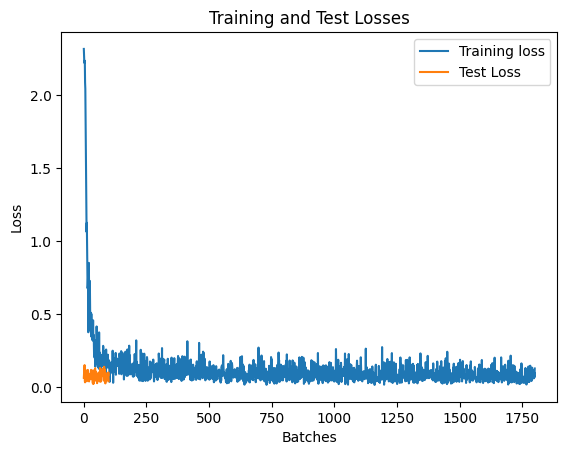

In [13]:
plt.plot(train_losses, label='Training loss')

#create X axis for testing losses
X_axis_test = [i*1 for i in range(len(test_losses))]

plt.plot(X_axis_test, test_losses, label='Test Loss')

plt.legend()
plt.title('Training and Test Losses')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.show()